# CI&A DeskDrop Dataset Analysis

## Introduction
Deskdrop is an internal communications platform developed by CI&T, focused in companies using Google G Suite. Among other features, this platform allows companies employees to share relevant articles with their peers, and collaborate around them.

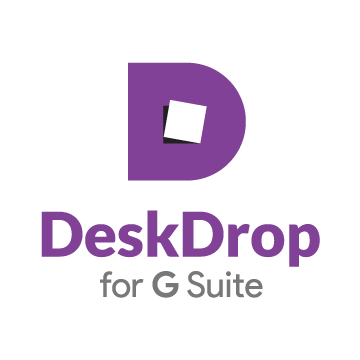




This project has three goals:
1. Explore the dataset and draw insights of the datasets.
2. Perform topic modeling to find out the main topics of the article dataset.
3. Establish a recommender system that recommends articles to the users using popularity model, collaborative filtering, content-based filtering and hybrid method.

## Load the data: CI&T Deskdrop Dataset

**shared_articles.csv:** This dataset contains information about articles shared on the platform.<br>


**users_interactions.csv:** This dataset contains information about users' interactions with the articles on the platform.<br>

More information about the datasets: https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop

In [1]:
# Change the working file directory
import os 
os.chdir("drive/MyDrive/Data")

In [2]:
# Import articles.csv and make a copy
import pandas as pd
articles_df = pd.read_csv('shared_articles.csv')
articles_copy = articles_df.copy()
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [3]:
# Import users_interactions.csv and make a copy
interactions_df = pd.read_csv('users_interactions.csv')
interactions_copy = interactions_df.copy()
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


## EDA 

In [4]:
# Import essential libraries
import pandas as pd
from datetime import datetime
import re

### Users Interactions
First, we explore users_interactions.csv by features.

#### timestamp
contains information about the time when the interactions happened.

In [5]:
# Time period covered by the dataset
def to_datetime(ts):
  return datetime.fromtimestamp(ts)

def to_datetime_str(ts):
  return to_datetime(ts).strftime('%Y-%m-%d %H:%M:%S')

print('First Interaction: \t%s' % to_datetime_str(interactions_df['timestamp'].min()))
print('Last Interaction: \t%s' % to_datetime_str(interactions_df['timestamp'].max()))

First Interaction: 	2016-03-14 13:54:36
Last Interaction: 	2017-02-28 19:21:51


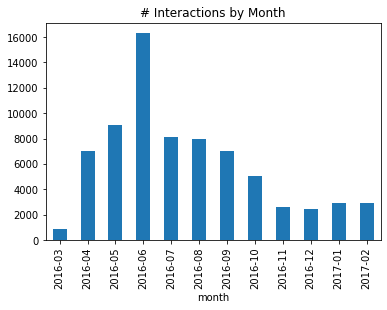

In [6]:
# Plot the time distribution of the users' interactions
interactions_df['datetime'] = interactions_df['timestamp'].apply(lambda x: to_datetime(x))
interactions_df['month'] = interactions_df['datetime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
interactions_df.groupby('month').size().plot(kind='bar', title = '# Interactions by Month')

#### eventType

Here is the description of event types:


*   VIEW: The user has opened the article
*   LIKE: The user has liked the article
*   COMMENT CREATED: The user created a comment in the article
*   FOLLOW: The user chose to be notified on any new comment in the article
*   BOOKMARK: The user has bookmarked the article for easy return in the future







In [7]:
# Number of transactions of each type
interactions_df.groupby('eventType').size().sort_values(ascending=False)

eventType
VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
dtype: int64

In [8]:
# Number of articles, users, user sessions
print('Distinct articles: \t%d' % len(interactions_df['contentId'].unique()))
print('Distinct users: \t%d' % len(interactions_df['personId'].unique()))
print('Distinct user sessions: \t%d' % len(interactions_df['sessionId'].unique()))

Distinct articles: 	2987
Distinct users: 	1895
Distinct user sessions: 	28740


In [9]:
# Describe number of interactions made by each user 
interactions_df.groupby('personId')['contentId'].size().describe()

count    1895.000000
mean       38.159367
std       104.143355
min         1.000000
25%         3.000000
50%        10.000000
75%        32.000000
max      1885.000000
Name: contentId, dtype: float64

Observe that more than 50% users have interacted with 10 or more articles. This analysis is important to recommender system.

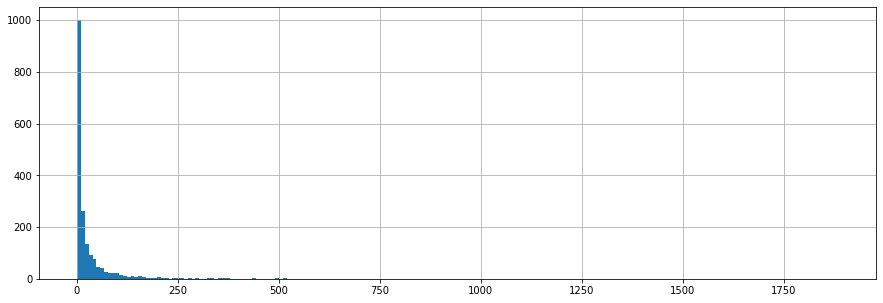

In [10]:
# Distribution of number of interactions made by individual user
interactions_df.groupby('personId')['contentId'].size().hist(bins=200, figsize=(15,5))

#### userAgent
contains the information of how uses access the platform

In [11]:
# Count the number of different values of userAgent
interactions_df['userAgent'].value_counts()

Android - Native Mobile App                                                                                                                   6761
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                1823
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                1146
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36                                     1076
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36                                 1059
                                                                                                                                              ... 
Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2794.0 Safari/537.36      

Most interactions are from Android Mobile App. It can be conclude that most of the platform users are Android users.

In [12]:
# Number of interactions using different userAgent
total = len(interactions_df)
android = len(interactions_df[interactions_df['userAgent']=='Android - Native Mobile App'])
iOS = len(interactions_df[interactions_df['userAgent']=='iOS - Native Mobile App'])

print ('# of interactions (total): \t%d' % total)
print ('# of interactions (Android Mobile App): \t%d' % android)
print ('# of interactions (iOS Mobile App): \t%d' % iOS)

# of interactions (total): 	72312
# of interactions (Android Mobile App): 	6761
# of interactions (iOS Mobile App): 	103


We can see that for the 72312 interactions, 6761 interactions are from Andriod users and 103 interactions are from iOS users.

#### userCountry

In [13]:
# Count number of interactions of different countries
interactions_df['userCountry'].value_counts()

BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
SG       11
ZZ       11
AR        7
PT        6
IN        3
ES        3
IT        2
MY        2
NL        1
CO        1
CL        1
CH        1
CN        1
Name: userCountry, dtype: int64

In [14]:
# Convert country code back to country name
country_code_dict = {
    'BR': ('BRA', 'Brazil'),
    'US': ('USA', 'United States'),
    'KR': ('KOR', 'South Korea'),
    'CA': ('CAN', 'Canada'),
    'JP': ('JPN', 'Japan'),
    'AU': ('AUS', 'Australia'),
    'GB': ('GBR', 'United Kingdom'),
    'DE': ('DEU', 'Germany'),
    'DE': ('DEU', 'Germany'),
    'IE': ('IRL', 'Ireland'),
    'IS': ('ISL', 'Iceland'),
    'SG': ('SGP', 'Singapure'),
    'AR': ('ARG', 'Argentina'),
    'PT': ('PRT', 'Portugal'),
    'IN': ('IND', 'India'),
    'ES': ('ESP', 'Spain'),
    'IT': ('ITA', 'Italy'),
    'MY': ('MYS', 'Malaysia'),
    'CO': ('COL', 'Colombia'),
    'CN': ('CHN', 'China'),
    'CL': ('CHL', 'Chile'),
    'NL': ('NLD', 'Netherlands')
}

interactions_df['countryName'] = interactions_df['userCountry'].apply(lambda x: country_code_dict[x][1] if x in country_code_dict else None)
interactions_df[['userCountry','countryName']].head(10)

,userCountry,countryName
0,NaN,None
1,US,United States
2,NaN,None
3,NaN,None
4,NaN,None
5,BR,Brazil
6,NaN,None
7,BR,Brazil
8,NaN,None
9,NaN,None


In [15]:
# Count number of interactions from different countries
interactions_by_country_df = pd.DataFrame(interactions_df.groupby('countryName').size() \
                            .sort_values(ascending=False).reset_index())
interactions_by_country_df.columns = ['country', 'count']
interactions_by_country_df

,country,count
0,Brazil,51396
1,United States,4657
2,South Korea,239
3,Canada,226
4,Japan,144
5,Australia,138
6,United Kingdom,22
7,Germany,19
8,Ireland,14
9,Iceland,13


In [16]:
# Enable use of plotly in colab
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [17]:
# Plot a heap map
configure_plotly_browser_state()
import plotly.offline as py
py.offline.init_notebook_mode()
data = [ dict(
        type = 'choropleth',
        locations = interactions_by_country_df['country'],
        z = interactions_by_country_df['count'],
        locationmode = 'country names',
        text = interactions_by_country_df['country'],
        colorscale = [[0,"rgb(153, 241, 243)"],[0.005,"rgb(16, 64, 143)"],[1,"rgb(0, 0, 0)"]],
        autocolorscale = False,
        marker = dict(
            line = dict(color = 'rgb(58,100,69)', width = 0.6)),
            colorbar = dict(autotick = True, tickprefix = '', title = '# of Interactions')
            )
       ]

layout = dict(
    title = 'Total number of interactions by country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
        type = 'equirectangular'
        ),
    margin = dict(b = 0, t = 0, l = 0, r = 0)
            )
    )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')

Output hidden; open in https://colab.research.google.com to view.

Top 5 users' countries:
1. Brazil
2. United States
3. South Korea
4. Canada
5. Japan

#### userRegion

In [18]:
interactions_df['userCountryRegion'] = interactions_df['userCountry']+'-'+interactions_df['userRegion']
interactions_df.groupby('userCountryRegion').size().sort_values(ascending=False).head(10)

userCountryRegion
BR-SP    40164
BR-MG    10229
US-NY     1257
US-TX      923
US-GA      910
BR-RJ      775
US-NJ      698
US-CA      238
CA-ON      202
KR-?       165
dtype: int64

### Shared Articles

In [19]:
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


#### timestamp

In [20]:
print('First article sharing: \t%s' % to_datetime(articles_df['timestamp'].min()))
print('Last article sharing: \t%s' % to_datetime(articles_df['timestamp'].max()))

First article sharing: 	2016-03-28 19:19:39
Last article sharing: 	2017-02-28 18:51:11


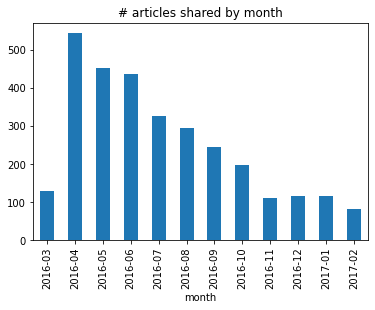

In [21]:
articles_df['datetime'] = articles_df['timestamp'].apply(lambda x: to_datetime(x))
articles_df['month']  = articles_df['datetime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
articles_df[articles_df['eventType'] == 'CONTENT SHARED'].groupby('month').size() \
        .plot(kind='bar', title='# articles shared by month')

Number of articles shared in April is the highest among the time range and this number decreases after April.

#### eventType

In [22]:
articles_df.value_counts('eventType')

eventType
CONTENT SHARED     3047
CONTENT REMOVED      75
dtype: int64

In [23]:
print('Distinct Articles: \t%d' % len(articles_df['contentId'].unique()))
print('Distinct Sharers: \t%d' % len(articles_df['authorPersonId'].unique()))

Distinct Articles: 	3057
Distinct Sharers: 	252


There are 3057 distinct articles shared on this platform but there are only 252 sharers.

#### contentType

In [24]:
articles_df.value_counts('contentType')

contentType
HTML     3101
VIDEO      11
RICH       10
dtype: int64

Most articles are shared in the format of HTML.

#### lang (language)

In [25]:
articles_df.value_counts('lang')

lang
en    2264
pt     850
la       4
ja       2
es       2
dtype: int64

Most articles are in English but there are also some articles in Portuguese, Latin, Japanese and Spanish.

#### url

In [26]:
articles_df['urlDomain'] = articles_df['url'].apply(lambda x: re.sub(r'^http[s]*:\/\/', '', re.search(r'^http[s]*:\/\/[\w\.]*', x, re.IGNORECASE).group(0)))
articles_df[['urlDomain','url']].head()

,urlDomain,url
0,www.nytimes.com,http://www.nytimes.com/2016/03/28/business/dea...
1,www.nytimes.com,http://www.nytimes.com/2016/03/28/business/dea...
2,cointelegraph.com,http://cointelegraph.com/news/bitcoin-future-w...
3,cloudplatform.googleblog.com,https://cloudplatform.googleblog.com/2016/03/G...
4,bitcoinmagazine.com,https://bitcoinmagazine.com/articles/ibm-wants...


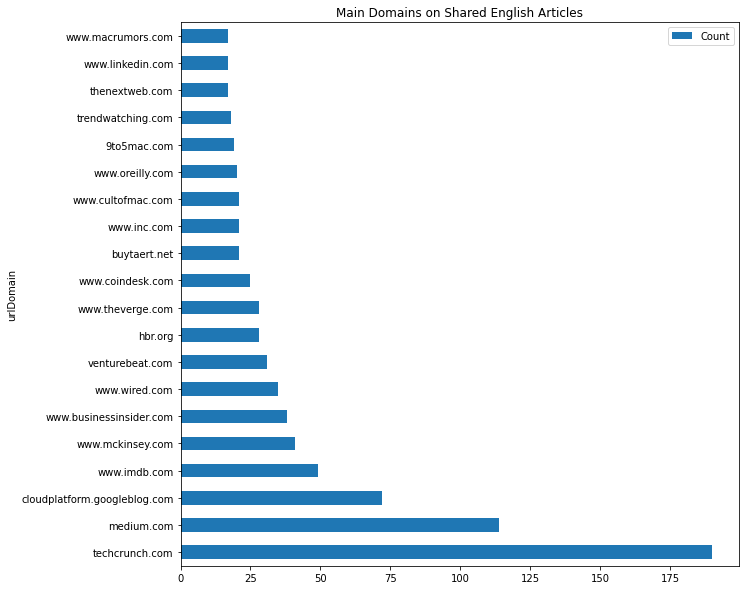

In [27]:
main_domains_df = pd.DataFrame(articles_df[articles_df['lang']=='en'].value_counts('urlDomain').sort_values(ascending=False)).reset_index()[:20]
main_domains_df.columns = ['urlDomain','Count']
main_domains_df.plot(kind='barh', x = 'urlDomain', y ='Count', figsize=(10,10), title = 'Main Domains on Shared English Articles')

This plot shows the main sources of the articles shared on the platform. The biggest source is tchcrunch.com.

## Articles Topic Modeling

In this section, we apply Topic Modeling to discover what are the main topics of the articles. We use Latent Dirichlet Allocation method here, implemented with Gensim framework.

In [28]:
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,datetime,month,urlDomain
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,2016-03-28 19:19:39,2016-03,www.nytimes.com
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,2016-03-28 19:39:48,2016-03,www.nytimes.com
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,2016-03-28 19:42:26,2016-03,cointelegraph.com
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,2016-03-28 19:47:54,2016-03,cloudplatform.googleblog.com
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,2016-03-28 19:48:17,2016-03,bitcoinmagazine.com


In [29]:
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
#Filtering only English articles
english_articles_df = articles_df[articles_df['lang'] == 'en']
#Concatenating the articles titles and bodies
english_articles_content = (english_articles_df['title'] + ' ' + english_articles_df['text']).tolist()

In [32]:
#Loading a set of English stopwords
english_stopset = set(stopwords.words('english')).union(
                  {"things", "that's", "something", "take", "don't", "may", "want", "you're", 
                   "set", "might", "says", "including", "lot", "much", "said", "know", 
                   "good", "step", "often", "going", "thing", "things", "think",
                  "back", "actually", "better", "look", "find", "right", "example", 
                   "verb", "verbs"})

In [33]:
#Tokenizing words of articles
tokenizer = RegexpTokenizer(r"(?u)[\b\#a-zA-Z][\w&-_]+\b")
english_articles_tokens = list(map(lambda d: [token for token in tokenizer.tokenize(d.lower()) if token not in english_stopset], english_articles_content))

In [34]:
#Processing bigrams from unigrams (sets of two works frequently together in the corpus)
bigram_transformer = models.Phrases(english_articles_tokens)
english_articles_unigrams_bigrams_tokens = list(bigram_transformer[english_articles_tokens])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [35]:
#Creating a dictionary and filtering out too rare and too common tokens
english_dictionary = corpora.Dictionary(english_articles_unigrams_bigrams_tokens)
english_dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=None)
english_dictionary.compactify()
print(english_dictionary)

Dictionary(17114 unique tokens: ['actual', 'advocates', 'agreed_upon', 'agreements', 'aim']...)


In [36]:
#Processing Bag-of-Words (BoW) for each article
english_articles_bow = [english_dictionary.doc2bow(doc) for doc in english_articles_unigrams_bigrams_tokens]

In [37]:
#Training the LDA topic model on English articles
lda_model = models.LdaModel(english_articles_bow, id2word=english_dictionary, num_topics=30, passes=10, iterations=500)

In [38]:
#Processing the topics for each article
english_articles_lda = lda_model[english_articles_bow]

In [39]:
def get_topics_top_words(model, max_words):
    all_topics = model.show_topics(-1, max_words*2, False, False)
    topics = []
    for topic in all_topics:    
        min_score_word = float(abs(topic[1][0][1])) / 2.
        top_positive_words = list(map(lambda y: y[0].replace('_',' '), filter(lambda x: x[1] > min_score_word, topic[1])))[0:max_words]
        topics.append('[' + ', '.join(top_positive_words) + ']')
    return topics

#Computing the main topic of each article
topics_top_words = get_topics_top_words(lda_model, 5)

In [40]:
def get_main_topics(corpus_lda, topics_labels):
    min_strength = (1.0 / float(len(topics_labels))) + 0.01
    main_topics = map(lambda ts: sorted(ts, key=lambda t: -t[1])[0][0] if sorted(ts, key=lambda t: -t[1])[0][1] > min_strength else None, corpus_lda)
    main_topics_labels = map(lambda x: topics_labels[x] if x != None else '', main_topics)
    return list(main_topics_labels)

#Return the discovered topics, sorted by popularity
corpus_main_topics = get_main_topics(english_articles_lda, topics_top_words)

main_topics_df = pd.DataFrame(corpus_main_topics, columns=['topic']).groupby('topic').size().sort_values(ascending=True).reset_index()
main_topics_df.columns = ['topic','count']
main_topics_df.sort_values('count', ascending=False)

,topic,count
29,"[ai, technology, information, systems, google]",310
28,"[apple, computer]",249
27,"[service, services, applications, cloud, content]",181
26,"[code, file, version, project, java]",171
25,"[product, users, team, company, platform]",150
24,"[companies, business, design, digital, customers]",141
23,[google],103
22,[team],82
21,"[drupal, technology]",70
20,"[bot, api, bots]",62


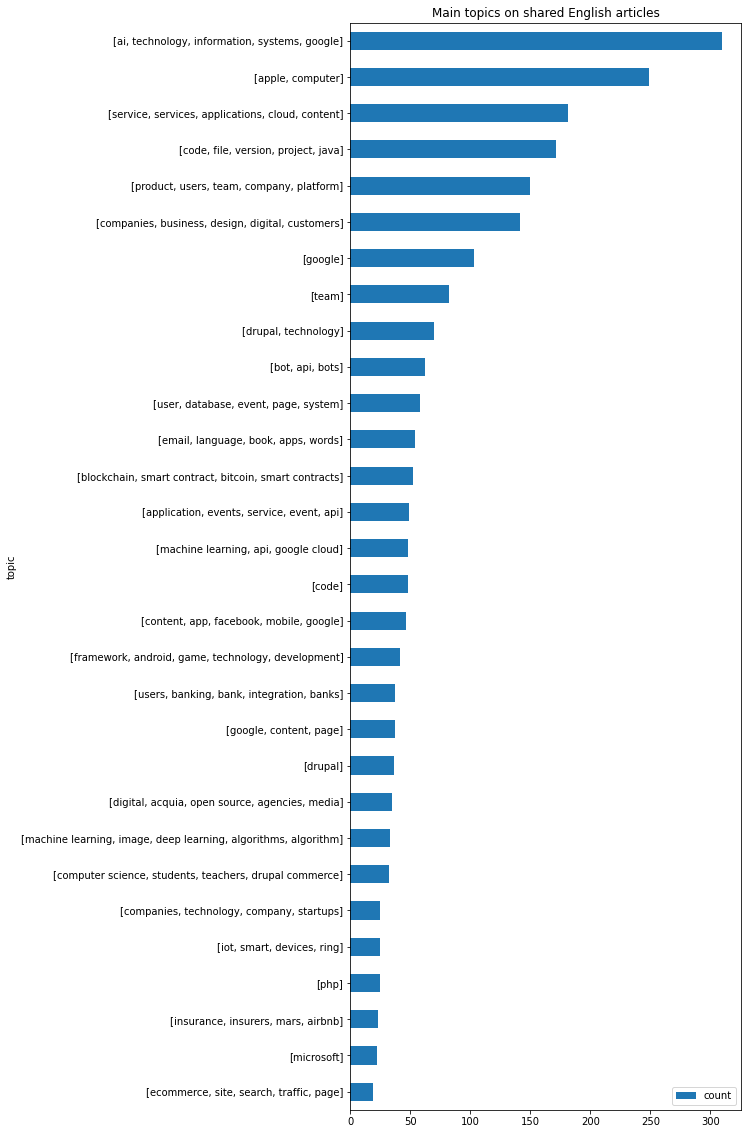

In [41]:
main_topics_df.plot(kind='barh', x='topic', y = 'count', figsize = (7,20), title = 'Main topics on shared English articles')

Top Article Tops:
1. [ai, technology, information, system, google]
2. [apple, computer]
3. [service, services, applications, cloud, content]
4. [code, file, version, project, java]
5. [product, users, team, company, platform]\
Most topics are technology related so this company might be a tech company.

## Recommender System

**Three Types of Recommender System**

**1.   Collaborative Filtering**\
     This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.


**2.   Content-based Filtering**\
This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.

**3.   Hybrid Methods**
Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

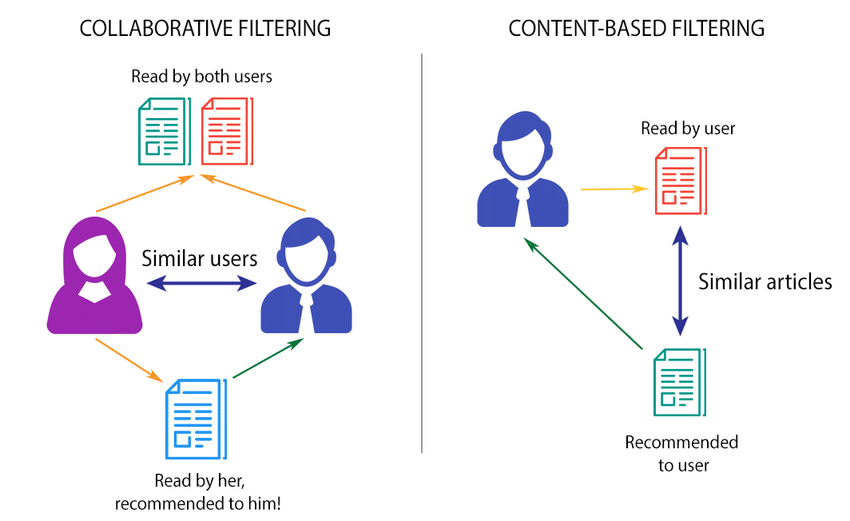

In [42]:
#Import the libraries
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [43]:
# Only consider shared articles 
articles = articles_copy[articles_copy['eventType'] == 'CONTENT SHARED']
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [44]:
interactions = interactions_copy.copy()
interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


### Data Preprocessing

In [45]:
# Give weight to each transaction type
event_type_strength = {
    'VIEW':1.0,
    'LIKE':2.0,
    'BOOKMARK':2.5,
    'FOLLOW':3.0,
    'COMMENT CREATED':4.0
}
interactions['eventStrength'] = interactions['eventType'].apply(lambda x: event_type_strength[x])

In [46]:
interactions['eventStrength'].value_counts()

1.0    61086
2.0     5745
2.5     2463
4.0     1611
3.0     1407
Name: eventStrength, dtype: int64

In [47]:
# Keep only users with at least 5 interactions 
interactions_count = interactions.groupby(['personId', 'contentId']).size().groupby('personId').size()
print ('# users: %d' % len(interactions_count))
users_enough_interactions = interactions_count[interactions_count >= 5].reset_index()[['personId']]
print ('# users with at least 5 interactions: %d' % len(users_enough_interactions))

# users: 1895
# users with at least 5 interactions: 1140


In [48]:
print('# interactions: %d' % len(interactions))
interactions_selected = interactions.merge(users_enough_interactions,
                                           how = 'right',
                                           on = 'personId')
print('# interactions from users with at least 5 interactions: %d' % len(interactions_selected))

# interactions: 72312
# interactions from users with at least 5 interactions: 69868


In [49]:
# Aggregate all interactions one user made to one item
# Define a log function to smooth the distribution
def log_func (x):
  return math.log(1+x, 2)

interactions_full = interactions_selected.groupby(['personId','contentId'])['eventStrength'].sum().apply(log_func).reset_index()

print('# unique user/item interactions: %d' % len(interactions_full))

interactions_full.head()

# unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


### Evaluation

Holdout, a simple cross-validation technique, is used here. 20% of the whole dataset is kept aside in the training process and used as test set in the evaluation process.

In [50]:
interactions_train, interactions_test = train_test_split(interactions_full, 
                                                         stratify=interactions_full['personId'],
                                                         test_size = 0.2,
                                                         random_state =42)
print('# interactions in training set: %d' % len(interactions_train))
print('# interactions in test set: %d' % len(interactions_test))

# interactions in training set: 31284
# interactions in test set: 7822


Top-N Accuracy metrics is used to evaluate the model. The accuracy of the top recommendations is evluated comparing to the items the users actually interact with.

In [51]:
# Index by personId to speed up the evaluation
interactions_full = interactions_full.set_index('personId')
interactions_train = interactions_train.set_index('personId')
interactions_test = interactions_test.set_index('personId')

In [52]:
def get_items(person_Id, df):
  item = df.loc[person_Id]['contentId']
  return set(item if type(item)==pd.Series else [item])

In [53]:
# Top-N constant
non_interact = 100

# Create a Class for evaluation
class ModelEvaluator:
  # Get non-interacted articles of a user
  def get_not_interacted (self, person_id, sample_size, seed=42):
    interacted_item = get_items(person_id, interactions_full)
    all_items = set(articles['contentId'])
    non_interacted = all_items - interacted_item
    random.seed(seed)
    non_interacted_sample = random.sample(non_interacted, sample_size)
    return set(non_interacted_sample)
  
  # Verify if one article is in the recommended list
  def verify (self, item_id, rec_list, topn):
    try:
      index = next(i for i, c in enumerate(rec_list) if c == item_id)
    except:
      index = -1
    hit = int(index in range(0, topn))
    return hit, index

  # Evaluate model for individual user
  def evaluate_user (self, model, person_id):
    # Get data from the test set
    interactions_user_test = interactions_test.loc[person_id]
    if type(interactions_user_test['contentId']) == pd.Series:
      user_item_test = set(interactions_user_test['contentId'])
    else:
      user_item_test = set([int(interactions_user_test['contentId'])])
    
    test_count = len(user_item_test)

    # Get the recommendation list from the model
    user_rec_list = model.recommend_items(person_id, 
                                          items_to_ignore = get_items(person_id, interactions_train),
                                          topn=10000000000)
    
    # Count of items in top 5/10 of rec list 
    hit_at_5_count = 0
    hit_at_10_count = 0

    # For each item the user has interacted in the test set
    for item_id in user_item_test:
      # Get a random sample (100) of non-interacted items (assumed not relevant to the user)
      non_interact_sample = self.get_not_interacted(person_id, 
                                                    sample_size = non_interact, 
                                                    seed = item_id%(2**32))

      # Combine the current item with the non-interacted sample
      items_to_filter = non_interact_sample.union(set([item_id]))

      # Filter the items in rec list that's in the sample
      valid_rec_df = user_rec_list[user_rec_list['contentId'].isin(items_to_filter)]
      valid_rec = valid_rec_df['contentId'].values

      # Verify if the current item is among the top-n recommended items
      hit_at_5, index_at_5 = self.verify(item_id, valid_rec, 5)
      hit_at_5_count += hit_at_5

      hit_at_10, index_at_10 = self.verify(item_id, valid_rec, 10)
      hit_at_10_count += hit_at_10

    # Calculate the recall (rate of interacted items that are recommended)
    recall_at_5 = hit_at_5_count / float(test_count)
    recall_at_10 = hit_at_10_count / float(test_count)

    # Retain these values in a dictionary
    user_metrics = {'hits_5': hit_at_5_count,
                    'hits_10': hit_at_10_count,
                    'interacted_count': test_count,
                    'recall_5':recall_at_5,
                    'recall_10':recall_at_10}
    return user_metrics
    
    # Evaluate the model in general
  def evaluate_model(self, model):
    user_metrics = []
    for idx, person_id in enumerate(list(interactions_test.index.unique().values)):
      individual_metrics = self.evaluate_user(model, person_id)
      individual_metrics['_person_id'] = person_id        
      user_metrics.append(individual_metrics)
    print ('%d users processed' % idx)
    detailed_results_df = pd.DataFrame(user_metrics).sort_values('interacted_count', ascending=False)
    global_recall_5 = detailed_results_df['hits_5'].sum() / float(detailed_results_df['interacted_count'].sum())      
    global_recall_10 = detailed_results_df['hits_10'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_metrics = {'modelName':model.get_model_name(),
                      'recall_5': global_recall_5,
                      'recall_10':global_recall_10}
    return global_metrics, detailed_results_df

model_eval = ModelEvaluator()

### Popularity Model

In [54]:
# Compute the most popular items
item_pop_df = interactions_full.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_pop_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [55]:
class PopularityRecommender:
  MODEL_NAME = 'Popularity'

  def __init__(self, popularity_df, items_df = None):
    self.popularity_df = popularity_df
    self.items_df = items_df
  
  def get_model_name(self):
    return self.MODEL_NAME

  def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose = False):
    # Recommend the most popular item the user hasn't interacted with
    rec_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)].sort_values('eventStrength', ascending = False).head(topn)
    if verbose:
      if self.items_df is None:
        raise Exception('"items_df" is required in verbose mode')
      rec_df = rec_df.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = contentId)[['eventStrength', 'contentId', 'title', 'url', 'lang']]
    return rec_df

popularity_model = PopularityRecommender(item_pop_df, articles_df)

In [56]:
print('Evaluating Popularity Recommendation System ......')
pop_global_metrics, pop_detailed_results_df = model_eval.evaluate_model(popularity_model)

print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity Recommendation System ......
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall_5': 0.2417540271030427, 'recall_10': 0.37292252620813093}


,hits_5,hits_10,interacted_count,recall_5,recall_10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,25,40,88,0.284091,0.454545,-2979881261169775358
161,12,18,80,0.150000,0.225000,-3596626804281480007
65,20,33,73,0.273973,0.452055,1116121227607581999
81,17,23,69,0.246377,0.333333,692689608292948411
106,14,18,69,0.202899,0.260870,-9016528795238256703
52,21,28,68,0.308824,0.411765,3636910968448833585


### Content-Based Filtering Model

In [57]:
# Ignoring stopwords in English and Portugue
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

# Train the model
vectorizer = TfidfVectorizer(analyzer = 'word',
                             ngram_range = (1,2),
                             min_df = 0.003,
                             max_df = 0.5,
                             max_features = 5000,
                             stop_words = stopwords_list)
item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + " " + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3122x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 653941 stored elements in Compressed Sparse Row format>

In [58]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train[interactions_train['contentId'] \
                                                   .isin(articles['contentId'])]
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [59]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [60]:
# Take a look at one of the profile 
profile = user_profiles[-1479311724257856983]
print(profile.shape)

pd.DataFrame(sorted(zip(tfidf_feature_names,
                        profile.flatten().tolist()),
                        key = lambda x: -x[1])[:20],
                    columns = ['Token', 'Relevance'])

(1, 5000)


,Token,Relevance
0,learning,0.297598
1,machine learning,0.247989
2,machine,0.239653
3,google,0.207478
4,data,0.169165
5,ai,0.158463
6,algorithms,0.113991
7,like,0.096982
8,language,0.087233
9,deep learning,0.081753


In [61]:
class ContentBasedRecommender:

  MODEL_NAME = 'Content-Based'

  def __init__(self, items_df = None):
    self.item_ids = item_ids
    self.item_df = items_df

  def get_model_name(self):
    return self.MODEL_NAME
  
  def get_similar_items(self, person_id, topn = 1000):
    # Computer the cosine similarity between the user profile and the full item profile
    cos_similarity = cosine_similarity(user_profiles[person_id], tfidf_matrix)

    # Get top similar items
    similar_indices = cos_similarity.argsort().flatten()[-topn:]

    # Sort the similar items by similarity
    similar_items = sorted([(item_ids[i], cos_similarity[0,i]) for i in similar_indices], key = lambda x: -x[1])
    return similar_items
  
  def recommend_items(self, user_id, items_to_ignore = [], topn=10, verbose = False):
    similar_items = self.get_similar_items(user_id)

    # Ignore items that the user alrealy interacted
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
    rec_df = pd.DataFrame(similar_items_filtered, columns = ['contentId', 'recStrength']).head(topn)

    if verbose:
      if self.item_df.empty:
        raise Exception('"items_df" is required in verbose mode')
      rec_df = rec_df.merge(self.item_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]
    return rec_df

content_based_recommender_model = ContentBasedRecommender(articles)

In [62]:
print('Evaluating Content-Based Filtering model......')
cb_global_metrics, cb_detailed_results_df = model_eval.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model......
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall_5': 0.1640245461518793, 'recall_10': 0.26118639734083354}


,hits_5,hits_10,interacted_count,recall_5,recall_10,_person_id
76,14,25,192,0.072917,0.130208,3609194402293569455
17,17,31,134,0.126866,0.231343,-2626634673110551643
16,18,33,130,0.138462,0.253846,-1032019229384696495
10,32,49,117,0.273504,0.418803,-1443636648652872475
82,6,14,88,0.068182,0.159091,-2979881261169775358
161,11,20,80,0.137500,0.250000,-3596626804281480007
65,7,12,73,0.095890,0.164384,1116121227607581999
81,8,18,69,0.115942,0.260870,692689608292948411
106,3,9,69,0.043478,0.130435,-9016528795238256703
52,3,8,68,0.044118,0.117647,3636910968448833585


### Collaborative Filtering Model

#### Matrix Factorization

In [63]:
# Creating a table with users in rows and items in columns
users_items_df = interactions_train.reset_index().pivot(index='personId',
                                          columns = 'contentId',
                                          values = 'eventStrength').fillna(0)
users_items_df.head()

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,...,8962537427807366481,8963770574956550187,8963938873430212934,8968837261991914049,8969476626572775042,8974280745225397183,8982094176562780806,8993230615635349817,9004099881383415529,9026402401132606773,9028580484484026894,9032993320407723266,9033884391004475493,9038543365726770177,9042192299854648021,9045808098977760576,9054050762437897017,9056727675613132316,9060231864899459154,9079880752026843473,9091641298512813712,9112765177685685246,9121100366909552616,9122627895188486603,9124439338148818380,9128267824356972069,9136323715291453594,9151634133568930081,9168028029170358424,9175693555063886126,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
users_item_matrix = users_items_df.values
users_item_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
users_ids = list(users_items_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [66]:
users_items_sparse = csr_matrix(users_item_matrix)
users_items_sparse

<1140x2926 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [67]:
# Number of factors to factorize the user matrix
num_factor = 15

# Matrix Factorization
U, sigma, Vt = svds(users_items_sparse, k = num_factor)

In [68]:
U.shape

(1140, 15)

In [69]:
Vt.shape

(15, 2926)

In [70]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [71]:
all_users_pred_ratings = np.dot(np.dot(U, sigma), Vt)
all_users_pred_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [72]:
all_users_pred_norm = (all_users_pred_ratings - all_users_pred_ratings.min()) / (all_users_pred_ratings.max() - all_users_pred_ratings.min())

In [73]:
# Convert matrix back to DataFrame
cf_pred_df = pd.DataFrame(all_users_pred_norm, columns = users_items_df.columns, index = users_ids).transpose()
cf_pred_df.head()

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,-9063420486253202900,-9060214117327732109,-9047547311469006438,-9016528795238256703,-9009798162809551896,-9001583565812478106,-8994220765455693336,-8909668725653743114,-8891033171626175843,-8860671864164757449,-8854674432071487111,-8853658195208337106,-8845298781299428018,-8830250090736356260,-8823950498314351783,-8802075878443651241,-8784674845716296727,-8781635134606732409,-8781306637602263252,-8763398617720485024,-8738496712327699923,-8719462623048086192,-8704807962619440953,-8699750646678621887,-8694104221113176052,-8686631410634491662,-8674958742744576254,-8672331451814079632,-8670749047273764903,-8652741825481604192,...,8791271631167250981,8801420707973230165,8801970869404590779,8813266398846460512,8841741572929644986,8847054836611412804,8855523843512271162,8862260182894039021,8872819156169667456,8874741321583329336,8879844298911979276,8892482595912468268,8907499588729810535,8913362709216003291,8920667914865172372,8940614478925413056,8941502917401491878,8961723342122872302,8965285988346645117,8968131284214320024,8982783231149017560,8992729171160464416,9013651444868609421,9033898219489253274,9037410398700100618,9038446466275805109,9050204922960952289,9090527742744334314,9091970136990402395,9102085903669288476,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.139129,0.137930,0.136531,0.143948,0.136815,0.137339,0.137508,0.143534,0.136428,0.135681,0.136873,0.138129,0.136588,0.130577,0.150717,0.142606,0.136765,0.137352,0.134002,0.124023,0.136944,0.133141,0.185105,0.134144,0.137539,0.137903,0.137115,0.137101,0.138658,0.144550,0.134712,0.142815,0.137962,0.137030,0.153129,0.137575,0.141602,0.134200,0.133515,0.138167,...,0.137972,0.140265,0.135848,0.140562,0.135223,0.137119,0.139497,0.135881,0.136262,0.136875,0.135751,0.137961,0.137583,0.137657,0.138469,0.136019,0.138092,0.137739,0.137670,0.195783,0.137108,0.135888,0.137397,0.136848,0.138275,0.138327,0.137143,0.137248,0.139015,0.141458,0.137351,0.127822,0.137946,0.139653,0.140324,0.136888,0.135787,0.134560,0.135862,0.136246
-9216926795620865886,0.138044,0.137916,0.138698,0.137878,0.137969,0.137990,0.137974,0.138049,0.138217,0.138151,0.138030,0.137906,0.137802,0.139819,0.139060,0.138581,0.138495,0.138178,0.138921,0.142132,0.138560,0.140137,0.136909,0.137947,0.138055,0.138029,0.138159,0.137973,0.138319,0.139002,0.138095,0.138327,0.137942,0.138777,0.138120,0.137983,0.138999,0.138718,0.139083,0.137882,...,0.138007,0.138102,0.137982,0.138226,0.138274,0.137751,0.138323,0.138471,0.138529,0.137938,0.138427,0.138162,0.138104,0.137846,0.139777,0.138316,0.138128,0.138197,0.138029,0.140776,0.137905,0.138269,0.137898,0.138227,0.137861,0.138231,0.138039,0.137939,0.138106,0.137890,0.137962,0.139527,0.138009,0.138117,0.139634,0.138058,0.138222,0.138864,0.138480,0.138323
-9194572880052200111,0.135998,0.137652,0.137283,0.137536,0.140363,0.137807,0.141246,0.136284,0.135301,0.138512,0.140841,0.138711,0.139789,0.128246,0.144622,0.141345,0.137643,0.139323,0.137696,0.139703,0.137689,0.156370,0.125468,0.142828,0.138392,0.138221,0.140230,0.137840,0.148801,0.146963,0.136267,0.141754,0.138444,0.140615,0.131440,0.138559,0.147311,0.139779,0.147000,0.140466,...,0.137886,0.139455,0.137283,0.136793,0.139520,0.139865,0.146728,0.137552,0.142963,0.139664,0.144436,0.141681,0.139307,0.139046,0.138571,0.135371,0.139288,0.138132,0.137715,0.149994,0.138013,0.139390,0.137086,0.137759,0.137799,0.140283,0.138518,0.138112,0.139763,0.136812,0.139257,0.143161,0.139139,0.140077,0.154976,0.140109,0.140654,0.135861,0.139332,0.153114
-9192549002213406534,0.141924

In [74]:
len(cf_pred_df.columns)

1140

In [75]:
class CFRecommender:

  MODEL_NAME = 'Collaborative Filtering'

  def __init__(self, cf_pred_df, items_df = None):
    self.cf_pred_df = cf_pred_df
    self.items_df = items_df

  def get_model_name(self):
    return self.MODEL_NAME

  def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
    # Get and sort the user's prediction
    user_pred = self.cf_pred_df[user_id].sort_values(ascending = False).reset_index().rename(columns = {user_id:'recStrength'})

    # Recommend the highest rating movies the user hasn't seen
    rec_df = user_pred[~user_pred['contentId'].isin(items_to_ignore)].sort_values('recStrength', ascending=False).head(topn)

    if verbose:
      if self.items_df.empty:
        raise Exception('"items_df" is required in verbose mode.')
      rec_df = rec_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]
    return rec_df

cf_recommender_model = CFRecommender(cf_pred_df, articles)
                                                                        

In [76]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_eval.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall_5': 0.33405778573254924, 'recall_10': 0.46816670928151366}


,hits_5,hits_10,interacted_count,recall_5,recall_10,_person_id
76,21,45,192,0.109375,0.234375,3609194402293569455
17,30,56,134,0.223881,0.417910,-2626634673110551643
16,16,34,130,0.123077,0.261538,-1032019229384696495
10,38,51,117,0.324786,0.435897,-1443636648652872475
82,39,48,88,0.443182,0.545455,-2979881261169775358
161,22,34,80,0.275000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,23,30,68,0.338235,0.441176,3636910968448833585


### Hybrid Recommender

In [77]:
class HybridRecommender:

  MODEL_NAME = 'Hybrid'

  def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_weight = 1.0, cf_weight = 1.0):
    self.cb_rec_model = cb_rec_model
    self.cf_rec_model = cf_rec_model
    self.items_df = items_df
    self.cb_weight = cb_weight
    self.cf_weight = cf_weight
  
  def get_model_name (self):
    return self.MODEL_NAME
  
  def recommend_items (self, user_id, items_to_ignore=[], topn=10, verbose=False):
     
     # Get top 1000 recommended items with Content-based Filtering
     cb_recs_df = self.cb_rec_model.recommend_items(user_id, 
                                                   items_to_ignore = items_to_ignore, 
                                                   verbose = verbose, 
                                                   topn = 1000).rename(columns = {'recStrength': 'recStrengthCB'})
    
     # Get top 1000 recommended items with Collaborative Filtering
     cf_recs_df = self.cf_rec_model.recommend_items(user_id,
                                                   items_to_ignore = items_to_ignore,
                                                   verbose = verbose,
                                                   topn = 1000).rename(columns = {'recStrength': 'recStrengthCF'})
     
     # Combine the results
     rec_df = cb_recs_df.merge(cf_recs_df, 
                               how = 'outer', 
                               left_on = 'contentId',
                               right_on = 'contentId').fillna(0)
     
     # Compute the hybrid rating
     rec_df['recStrengthHybrid']  = (rec_df['recStrengthCF'] * self.cf_weight) + (rec_df['recStrengthCB'] * self.cb_weight)

     # Sort the recommendations by hybrid rating
     rec_df = rec_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

     if verbose:
       if self.items_df.empty:
         raise Exception ('"items_df" is required in verbose mode.')
       rec_df = rec_df.merge(self.items_df,
                              how = 'left',
                              left_on = 'contentId',
                              right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]
     return rec_df 

hybrid_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles, cb_weight=1.0, cf_weight = 100.0)


In [78]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_eval.evaluate_model(hybrid_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall_5': 0.34236768090002556, 'recall_10': 0.47992840705701867}


,hits_5,hits_10,interacted_count,recall_5,recall_10,_person_id
76,22,45,192,0.114583,0.234375,3609194402293569455
17,31,58,134,0.231343,0.432836,-2626634673110551643
16,21,38,130,0.161538,0.292308,-1032019229384696495
10,40,51,117,0.341880,0.435897,-1443636648652872475
82,38,50,88,0.431818,0.568182,-2979881261169775358
161,23,35,80,0.287500,0.437500,-3596626804281480007
65,23,32,73,0.315068,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,27,69,0.289855,0.391304,-9016528795238256703
52,22,29,68,0.323529,0.426471,3636910968448833585


### Comparing the Methods

In [79]:
all_metrics_df = pd.DataFrame([pop_global_metrics, cb_global_metrics, cf_global_metrics, hybrid_global_metrics]).set_index('modelName')
all_metrics_df

,recall_5,recall_10
modelName,,
Popularity,0.241754,0.372923
Content-Based,0.164025,0.261186
Collaborative Filtering,0.334058,0.468167
Hybrid,0.342368,0.479928


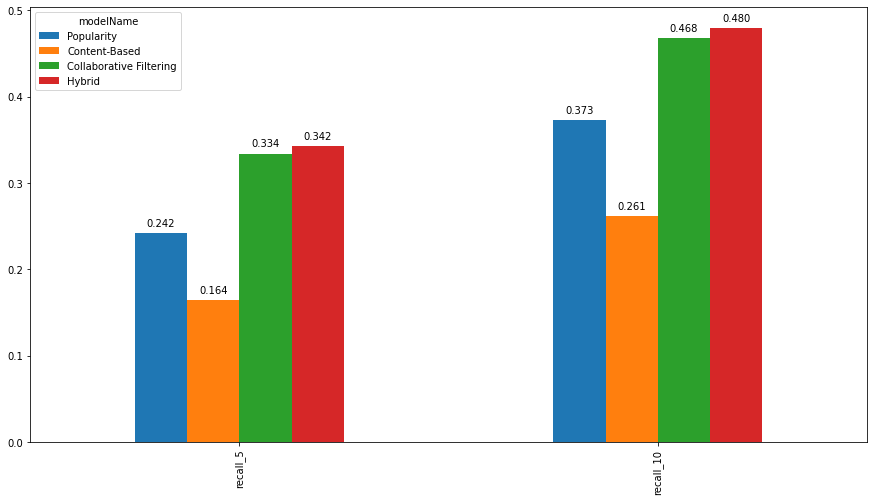

In [80]:
%matplotlib inline
ax = all_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

We can conclude that the hybrid recommender has the best performance which is the same to our expectation and the content-based recommender has the worst performance.

## Testing

In [81]:
def test(person_id, test_set = True):
  if test_set:
    interactions_df = interactions_indexed_df
  else:
    interactions_df = interactions_train
  return interactions_df.loc[person_id].merge(articles,
                                              how = 'left',
                                              left_on = 'contentId',
                                              right_on = 'contentId').sort_values('eventStrength', ascending = False)[['eventStrength', 'contentId', 'title', 'url', 'lang']]

In [82]:
test(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
28,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
43,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


In [83]:
hybrid_model.recommend_items(-1479311724257856983, topn=20, verbose = True)

,recStrengthHybrid,contentId,title,url,lang
0,25.437685,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,25.369932,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
2,24.493428,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
3,24.377488,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
4,24.362064,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
5,24.197546,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
6,24.172002,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,23.926692,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
8,23.866048,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
9,23.809426,1549650080907932816,Spark comparison: AWS vs. GCP,https://www.oreilly.com/ideas/spark-comparison...,en
